In [28]:
# imports
from typing import Callable

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from tqdm.notebook import trange

from solution import *

In [29]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

cpu


# Exercise 8 - Convolutional Neural Networks

In this exercise we will create and train convolutional neural networks on the PyTorch dataset.

We will first write functions for both creation of MLPs (already implemented) and CNNs. Then we will train multiple MLPs and CNNs on the CIFAR10 dataset and compare their performance and number of parameters, as well as visualize the feature maps of the CNN. Finally we will investigate the robustness of CNNs against small translations of images.

# Hyperparameters

In [30]:
TRAIN_SPLIT = 0.5
VAL_SPLIT = 0.05

BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 0.001

# Datasets

## Task 1 (10 P)
Use the `torch.utils.data.random_split()` function to further split the training set into train and validation set. Use the constants `TRAIN_SPLIT` and `VAL_SPLIT` as the percentages to take from the original training set.

In [31]:
dataset = CIFAR10("sample_data", train=True, transform=ToTensor(), download=True)

# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
train_set, val_set = solution_1_train_and_val_split(dataset, TRAIN_SPLIT, VAL_SPLIT)
# --------------------------------------------------

test_set = CIFAR10("sample_data", train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


# MLP

Implementation of MLP is given.

In [32]:
def create_mlp(input_shape: tuple[int, int, int], hidden_dims: list[int], n_classes: int):
    dims = [np.prod(input_shape), *hidden_dims, n_classes]

    layers = []
    for i in range(len(dims) - 1):
        if i < len(dims) - 2:
            layers.extend([nn.Linear(dims[i], dims[i+1]), nn.ReLU()])
        else:
            layers.extend([nn.Linear(dims[i], dims[i+1])])

    model = nn.Sequential(
        nn.Flatten(),
        *layers,
    )

    return model.to(DEVICE)

# CNN

## Task 2 (20 P)

Implement a CNN. Differently than in the previous tasks, the function should work for arbitrary input sizes, and an arbitrary number of classes.

The CNN consists of the convolutional part, and a final projection head, which will be a simple `nn.Linear()` layer.

The convolutional part consists of a list of convolutional blocks, which are of the form `nn.Conv2d(...)` → `nn.MaxPool(...)` →`nn.ReLU()`. For the convolutional block we will use a kernel size of 5, with a padding of 2, and the max pool layrs will use a a kernel size of 4 with a stride of 2 and a padding of 1. This ensures that the convolutions will keep the image height and width and the pooling layers will halve the image dimensions.

The Projection head maps the output of the convolutional part onto a vector of size `n_classes`, so that we can use the cross-entropy loss to optimize our classifier. Since the nn.Linear layer needs a fixed number of input features, but this function should work for arbitrary input sizes, you will have to figure out the output shape of the convolutional part programatically. This is, because the output of a convolutional layer depends not only on how we specify our layer, but also on the input size. Do not hardcode the input shape of the CIFAR dataset into the function.

It is possible to use the `create_mlp()` function above in this module, it is not necessary however.

In [33]:
def create_cnn(input_shape: tuple[int, int, int], channels: list[int], n_classes: int):
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    model = solution_2_create_cnn(input_shape, channels, n_classes, create_mlp)
    # --------------------------------------------------

    return model.to(DEVICE)

# Train and validation functions

The functions for training and evaluating the models are given.

In [34]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader,
                    optimizer: Optimizer, loss_fn: Callable):
    losses = []

    for batch, labels in train_loader:
        batch, labels = batch.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        preds = model(batch)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)


def validate(model: nn.Module, val_loader: DataLoader, loss_fn: Callable):
    losses = []

    model.eval()

    with torch.no_grad():
        for batch, labels in val_loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            preds = model(batch)
            loss = loss_fn(preds, labels)

            losses.append(loss.item())

    model.train()

    return np.mean(losses)


def train_model(model: nn.Module, train_loader, val_loader,
                optimizer: Optimizer, loss_fn: Callable, n_epochs: int,
                validate_every: int = 1):
    train_losses = []
    val_losses = []

    # stores the iterations in which we validated our model for plotting
    val_epochs = []

    progress_bar = trange(n_epochs)
    for epoch in progress_bar:
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)

        if epoch % validate_every == 0 or epoch in [1, n_epochs - 1]:
            val_loss = validate(model, val_loader, loss_fn)
            val_losses.append(val_loss)
            val_epochs.append(epoch)

        progress_bar.set_description(f"Train loss: {train_loss:.4f}\t Val loss: {val_loss:.4f}")

    # The first epoch often results in very high losses due to random guesses at
    # the beginning of training. To avoid the effect on the plot you may
    # uncomment the following line.

    # return train_losses[1:], val_losses[1:], [e-1 for e in val_epochs][1:]

    return train_losses, val_losses, val_epochs

## Task 3 (10 P)

Use the functions above to train three CNNs and three MLPs using the Adam optimizer with the provided learning rate. After having trained one MLP and one CNN, plot their validation and training losses as shown below. The progress bars are made using the `tqdm` package, in this case the `trange` function, but this is not a requirement for this task. The models should be appended to the lists `cnns` and `mlps`. The parameters for the functions for creating the models are given.

Training MLP no. 0 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Training CNN no. 0 ...


  0%|          | 0/5 [00:00<?, ?it/s]

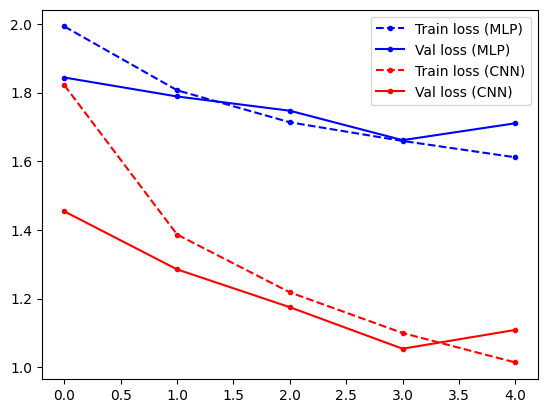

Training MLP no. 1 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Training CNN no. 1 ...


  0%|          | 0/5 [00:00<?, ?it/s]

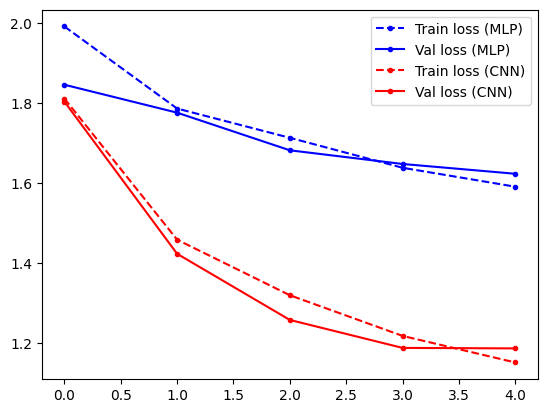

Training MLP no. 2 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Training CNN no. 2 ...


  0%|          | 0/5 [00:00<?, ?it/s]

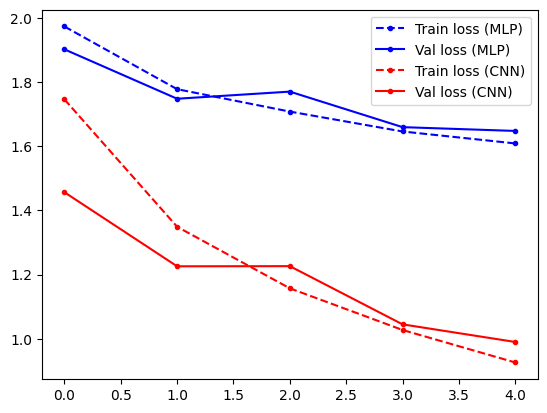

Trained 3 MLPs and 3 CNNs.


In [35]:
mlps: list[nn.Module] = []
cnns: list[nn.Module] = []

input_shape = (3, 32, 32)
cnn_channels = [64, 96, 128]
mlp_dims = [1024, 512, 64]
n_classes = 10

# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
mlps, cnns = solution_3_train_n_models(n_models=3,
                                       input_shape=input_shape,
                                       create_cnn=create_cnn,
                                       cnn_channels=cnn_channels,
                                       create_mlp=create_mlp,
                                       mlp_dims=mlp_dims,
                                       n_classes=n_classes,
                                       lr=LEARNING_RATE,
                                       n_epochs=EPOCHS,
                                       train_fn=train_model,
                                       train_loader=train_loader,
                                       val_loader=val_loader)
# --------------------------------------------------

print(f"Trained {len(mlps)} MLPs and {len(cnns)} CNNs.")

# Evaluation

## Task 4a - Accuracy (20 P)

You are given a function to compute the accuracy of a model on a given dataloader. Compute the accuracies of all the cnns and mlp and plot them as a [boxplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) as shown below.

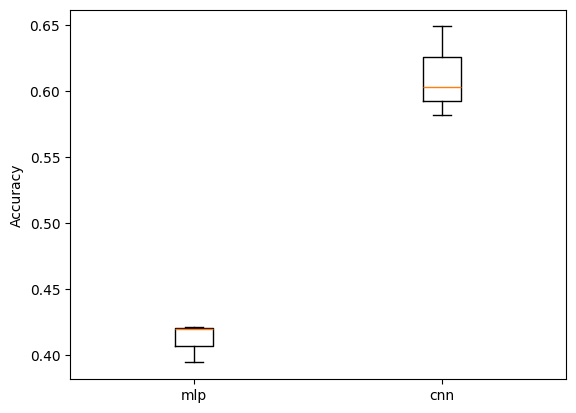

MLP mean: 0.4118539094924927, CNN mean: 0.6113858222961426


In [36]:
def get_accuracy(model: nn.Module, dataloader: DataLoader):
    """Compute accuary of modle on test set"""
    accuracies = []

    model.eval()

    with torch.no_grad():
        for batch, labels in dataloader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            preds = model(batch)
            accuracy = torch.mean((torch.argmax(preds, dim=-1) == labels).type(torch.FloatTensor))
            accuracies.append(accuracy)

    model.train()

    return np.mean(accuracies)

# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
solution_4a_accuracy_boxplots(get_accuracy_fn=get_accuracy,
                              mlps=mlps,
                              cnns=cnns,
                              dataloader=test_loader)
# --------------------------------------------------



## Task 4b - Number of parameters (10 P)

Write a function that returns the number of trainable weights of a model.

In [37]:
def count_params(model: nn.Module):
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    return solution_4b_count_params(model)
    # --------------------------------------------------


mlp_params = count_params(mlps[0])
print(f"MLP:\t{mlp_params} trainable paramerters")
cnn_params = count_params(cnns[0])
print(f"CNN:\t{cnn_params} trainable parameters")

print(f"\nCNN is ~{(mlp_params / cnn_params):.2f} times smaller than the MLP.")

MLP:	3705034 trainable paramerters
CNN:	486378 trainable parameters

CNN is ~7.62 times smaller than the MLP.


## Task 4c - Plot feature maps (20 P)

Visualize the feature maps of the convolutional neural networks.

A feature map is simply a single channel of some intermediate conv layer. E.g. in the above trained CNNs, the first conv layer outputs 32 channels. For each of these channels we get a 16 x 16 feature map. We will consider the feature map after applying the max pooling and relu activation. The feature map then can be visualized using matplotlib as a grayscale image. Make sure to normalize your images to the range [0,1].

Hint: You might want to use the `torchvision.utils.make_grid`.

Input image


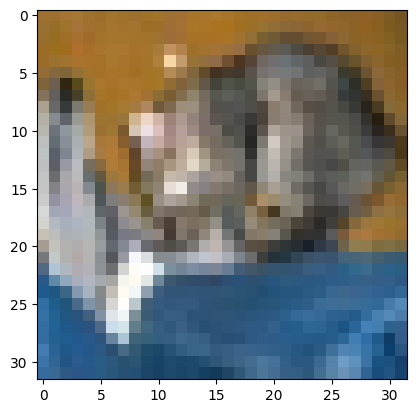

Layer 2 (ReLU())


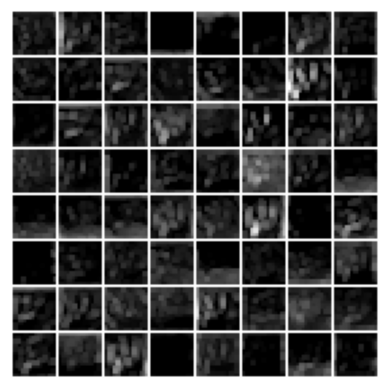

Layer 5 (ReLU())


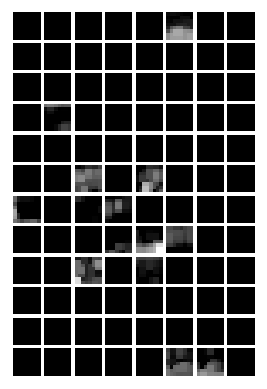

Layer 8 (ReLU())


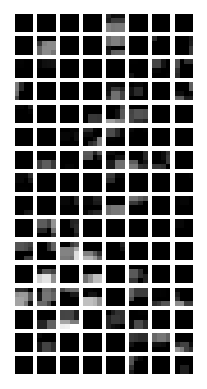

In [38]:
first_cifar_test_image = next(iter(test_loader))[0][0][None, :]
model = cnns[0]

# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
solution_4c_plot_feature_maps(model, first_cifar_test_image)
# --------------------------------------------------

# Robustness to translations of images

## Task 5 (10 P)

1. Create a new test set with translated images. You may use the `transform` argument of the `CIFAR10` class to apply translations of images. Though you are free to choose the method you prefer.
2. As in task 4a, compute the accuracies of the models on the modified test set with translated images.

Translation simply refers to shifting  the images a few pixels. As you can see in our example we have shifted the images by a maximum of 3/32 of its original size in both height and width (the `translate` argument), which results in a shift of max. 3 pixels.

You will note, that although the performance of both models is decreased, the MLPs suffer a higher decrease in accuracy.

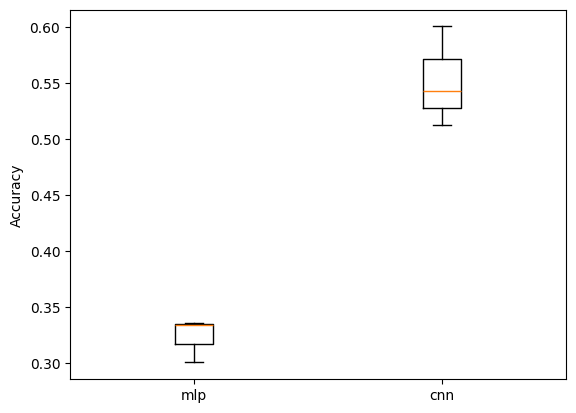

MLP mean: 0.3239385485649109, CNN mean: 0.5519185066223145


In [39]:
# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
solution_5_robustnes_to_translations(mlps=mlps,
                                     cnns=cnns,
                                     batch_size=BATCH_SIZE,
                                     get_accuracy_fn=get_accuracy,
                                     translate=(3 / 32, 3 / 32))
# --------------------------------------------------